In [89]:
import torch.nn as nn 
import torch
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from src import functions
from src import trainer
from src import models

In [ ]:
# Make data

# T = trainer.MoonTrainer(models.MLP321())
# T.train(1000)
# model = T.model

100%|██████████| 1000/1000 [00:02<00:00, 472.73it/s]

Training complete after 1000 epochs.
Total training: 1000 epochs.


In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden_sizes = hidden_sizes
        
        for i in range(len(hidden_sizes)):
            layer_name = f"l{i+1}"
            relu_name = f"relu{i+1}"
            if i == 0:
                
                setattr(self, layer_name, nn.Linear(input_size, hidden_sizes[i]))
                setattr(self, relu_name, nn.ReLU())
            else:
                setattr(self, layer_name, nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                setattr(self, relu_name, nn.ReLU())
                
        output_layer_name = f"l{len(hidden_sizes)+1}"

        setattr(self, output_layer_name, nn.Linear(hidden_sizes[-1], num_classes))

    def forward(self, x):
        out = x
        for i in range(len(self.hidden_sizes)):
            layer_name = f"l{i+1}"
            relu_name = f"relu{i+1}"
            out = getattr(self, layer_name)(out)
            out = getattr(self, relu_name)(out)

        output_layer_name = f"l{len(self.hidden_sizes)+1}"
        out = getattr(self, output_layer_name)(out)
        return out

100%|██████████| 1000/1000 [00:01<00:00, 507.79it/s]


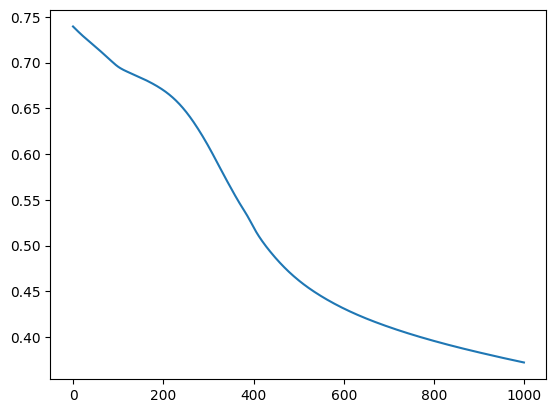

In [ ]:
x, y = make_moons(1000, noise=0.1)
x, y = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

def to_np(x):
    return x.cpu().detach().numpy()

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.l1 = nn.Linear(2, 3)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(3, 3)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(3, 3)
        self.relu3 = nn.ReLU()
        self.out = nn.Linear(3, 1)

    def forward(self, x):

        out = x
        out = self.relu1(self.l1(out))
        out = self.relu2(self.l2(out))
        out = self.relu3(self.l3(out))
        out = torch.sigmoid(self.out(out).squeeze())

        return out

EPOCHS = 1000
criterion = nn.BCELoss()

model = MLP()
optimizer = torch.optim.Adam(model.parameters())
losses = []

for epoch in trange(EPOCHS):
    model.train()
    optimizer.zero_grad()

    out = model(x)
    loss = criterion(out, y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    optimizer.zero_grad()

plt.figure(1)
plt.plot(losses)
plt.show()


In [102]:
model.eval()

MLP(
  (l1): Linear(in_features=2, out_features=3, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=3, out_features=3, bias=True)
  (relu2): ReLU()
  (l3): Linear(in_features=3, out_features=3, bias=True)
  (relu3): ReLU()
  (out): Linear(in_features=3, out_features=1, bias=True)
)

In [103]:
random_sample = x[0].float().unsqueeze(0).detach().numpy().T
random_sample.shape


(2, 1)

In [104]:
bit_vector_of_an_image  = functions.bit_vector_from_relus(model, random_sample, stack_layers = True, verbose=False, get_unique_bit_vectors_only=False)

In [105]:
print("Shape of the bit vector: ")
bit_vector_of_an_image[0].shape

Shape of the bit vector: 


(9, 1)

In [106]:
bit_vector_of_a_sample = functions.bit_vector_from_relus(model, random_sample, stack_layers=True, verbose=False, get_unique_bit_vectors_only=False)

In [107]:
print(bit_vector_of_a_sample)

[array([[1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])]


In [108]:
bit_vector_of_sample_no_stack  = functions.bit_vector_from_relus(model, random_sample, stack_layers = False, verbose=False, get_unique_bit_vectors_only=False)

In [109]:
counter = 1
for a_bit_vector in bit_vector_of_sample_no_stack[0]:
    print(f"Shape of the {counter}. hidden layer's bit vector: {a_bit_vector.shape}")
    counter += 1
    

Shape of the 1. hidden layer's bit vector: (3, 1)
Shape of the 2. hidden layer's bit vector: (3, 1)
Shape of the 3. hidden layer's bit vector: (3, 1)
